In [1]:
import tensorflow as tf
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
tf.config.threading.set_intra_op_parallelism_threads(cores)
tf.config.threading.set_inter_op_parallelism_threads(cores)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=6532d782091ef705bb2e68d8a2d7ed84d14d55b50c66b7e939b381119cb1b7df
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [2]:
### download dataset from openml using fetch_openml from sklearn
mnist_dataset = fetch_openml('mnist_784', as_frame=False)
## Split dataset to train and test sets
X, y = mnist_dataset.data, mnist_dataset.target
y = y.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
## Convert train and test dataset to tensorflow data
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))



In [4]:
test_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
random_index = np.random.randint(0, len(X_train), size=1)


Text(0.5, 1.0, 'Label: [9]')

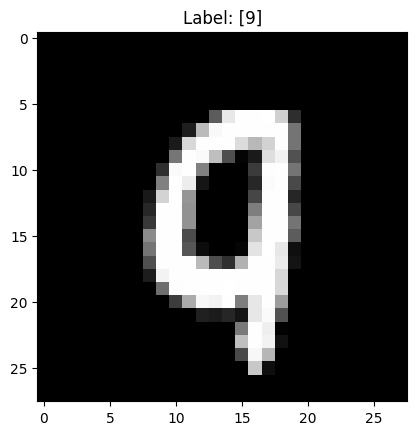

In [6]:
plt.imshow(X_train[random_index].reshape(28, 28), cmap='gray')
plt.title('Label: {}'.format(y_train[random_index]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26 255  90   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  26  26   0  13  64 138 180 199  11   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  41 224 232 207 221 253 242 162  17
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 195 253 210 160 161 111  38   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 151 236  50   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  38 247 134   0   0   0   0   0   0   0   0   

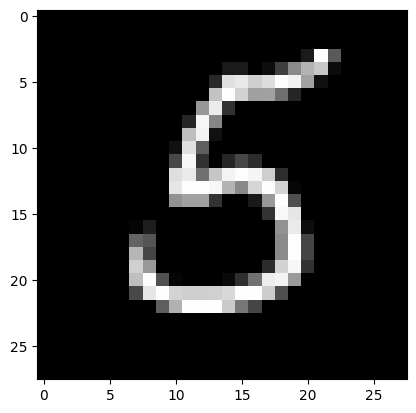

In [7]:
for item in train_data.take(1):
    plt.imshow(item[0].numpy().reshape(28,28), cmap='gray')
    print(item[0].numpy())
    input_shape = item[0].shape
    print(input_shape)


In [8]:
### Convert all pixel values to values between 0 and 1
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
train_data = train_data.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).prefetch(tf.data.AUTOTUNE)


train_size = int(len(train_data)*0.8)
train_dataset = train_data.take(train_size)
val_dataset = train_data.skip(train_size)

print(f'{len(train_dataset)} training samples')
print(f'{len(val_dataset)} validation samples')
print(f'{len(test_data)} test samples')

# Batch the datasets
train_dataset = train_data.batch(32)
val_dataset = val_dataset.batch(32)
test_data  = test_data.batch(32)

44800 training samples
11200 validation samples
14000 test samples


In [9]:
len(test_data)

438

In [10]:
for item in train_dataset.take(1):
    print(item)


(<tf.Tensor: shape=(32, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 7, 7, 4, 1, 1, 7, 3, 1, 7, 5, 0, 6, 7, 2, 6, 7, 4, 6, 7, 6, 9,
       2, 0, 0, 2, 1, 2, 9, 6, 3, 5])>)


In [11]:
# Construct a simple logistic model with one fully connected layer using "sigmoid" activation function
logistic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(784,)),
    tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_normal')  # ten classes for 10 possible labels of digits
])
logistic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    #,
    #tf.keras.metrics.Recall(name='recall'),
    #tf.keras.metrics.F1Score(name='f1_score', average='micro')
]


### complile model
logistic_model.compile(optimizer='Adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=metrics)

def callbacks_model(model_name):
  callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=10,
                                       restore_best_weights=True,
                                       monitor='val_accuracy',
                                       mode='max'),
      tf.keras.callbacks.ModelCheckpoint(filepath=model_name+".keras",
                                         save_best_only=True,
                                         mode='max')
  ]
  return callbacks


history = logistic_model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks_model('logistic_model'))

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8062 - loss: 0.7463 - val_accuracy: 0.9138 - val_loss: 0.3136
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9126 - loss: 0.3132 - val_accuracy: 0.9259 - val_loss: 0.2710
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9200 - loss: 0.2855 - val_accuracy: 0.9259 - val_loss: 0.2611
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9235 - loss: 0.2699 - val_accuracy: 0.9328 - val_loss: 0.2426
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9258 - loss: 0.2688 - val_accuracy: 0.9335 - val_loss: 0.2401
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9278 - loss: 0.2628 - val_accuracy: 0.9349 - val_loss: 0.2384
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9279 - loss: 0.2598 - val_accuracy: 0.9352 - val_loss: 0.2397
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9300 - loss: 0.2547 

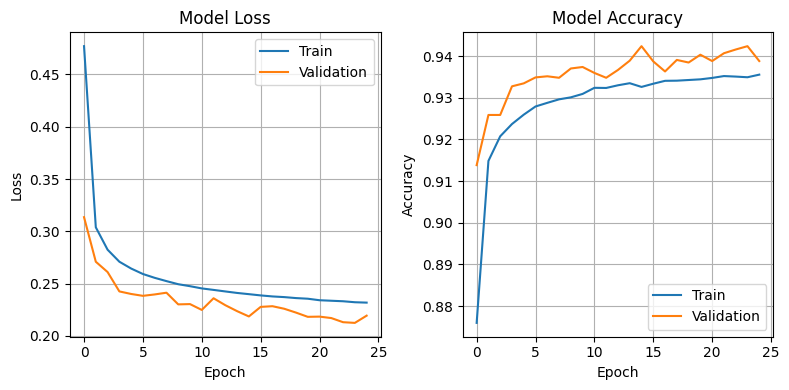

In [13]:
def plot_training_hist(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_hist(history)

In [14]:
### evaluate the model
logistic_model.evaluate(test_data, return_dict=True)
#test_data

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9241 - loss: 0.2823


{'accuracy': 0.9233571290969849, 'loss': 0.28367987275123596}

In [15]:
## Generate prediction values from the trained model, and extracl
logistic_model = tf.keras.models.load_model("logistic_model.keras")
test_results = logistic_model.evaluate(test_data, return_dict=True)

def get_predicted_labels(model, test_data):
    prediction_testset = []
    label_testset = []
    num_batch = len(test_data)
    i = 0
    for data, label in test_data:
      prediction_testset.extend(np.argmax(model.predict(data),axis=1))
      label_testset.extend(label.numpy())
      i += 1
      if i >= num_batch:
        break
    logistic_prediction_testset = np.array(prediction_testset)
    logistic_label_testset = np.array(label_testset)
    return logistic_prediction_testset, logistic_label_testset

logistic_prediction_testset, logistic_label_testset = get_predicted_labels(logistic_model, test_data)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9115 - loss: 0.3220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [16]:
cm = tf.math.confusion_matrix(logistic_label_testset, logistic_prediction_testset)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1295,    1,    8,    1,    1,    9,    9,    4,   11,    4],
       [   0, 1557,    7,    8,    2,    5,    2,    5,   12,    2],
       [   4,   17, 1236,   10,   21,    4,   24,   26,   31,    7],
       [   5,   11,   44, 1243,    0,   55,    9,   20,   30,   16],
       [   4,    4,   12,    0, 1165,    1,   11,    5,    9,   84],
       [  14,   13,    7,   46,   18, 1078,   17,    5,   63,   12],
       [   5,    6,   26,    1,   18,   18, 1315,    1,    6,    0],
       [  10,   16,   26,    2,    9,    3,    0, 1397,    3,   37],
       [  10,   36,   24,   33,    5,   27,   13,   15, 1169,   25],
       [   8,   10,   10,   13,   27,    7,    0,   47,    8, 1290]],
      dtype=int32)>

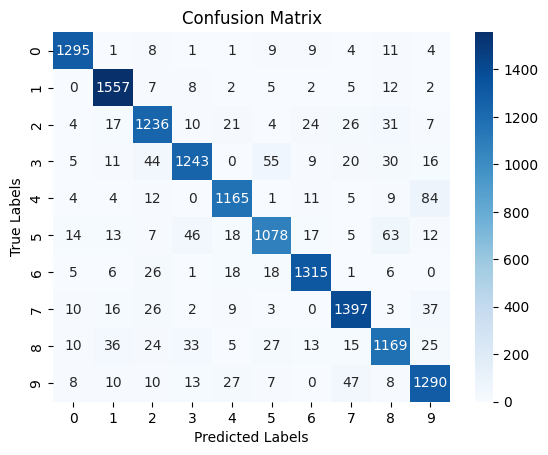

In [17]:
def cm_plot(cm):
  sns.heatmap(cm , annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

cm_plot(cm)

In [18]:
def callbacks_model(model_name):
  callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=10,
                                       restore_best_weights=True,
                                       monitor='val_accuracy',
                                       mode='max'),
      tf.keras.callbacks.ModelCheckpoint(filepath=model_name+".keras",
                                         save_best_only=True,
                                         mode='max')
  ]
  return callbacks

In [19]:
#### modify model structure to see if we can get better mode
logistic_model_3hlayers = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_normal')
])
logistic_model_3hlayers.compile(optimizer='Adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=metrics)
logistic_model_3hlayers.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
### train the model
history_3hlayers = logistic_model_3hlayers.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks_model("logistic_model_3hlayers"))

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9172 - loss: 0.3647 - val_accuracy: 0.9787 - val_loss: 0.0749
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9706 - loss: 0.0901 - val_accuracy: 0.9871 - val_loss: 0.0392
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9827 - loss: 0.0559 - val_accuracy: 0.9907 - val_loss: 0.0301
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9872 - loss: 0.0413 - val_accuracy: 0.9948 - val_loss: 0.0172
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9887 - loss: 0.0326 - val_accuracy: 0.9931 - val_loss: 0.0182
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9910 - loss: 0.0272 - val_accuracy: 0.9958 - val_loss: 0.0141
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9930 - loss: 0.0215 - val_accuracy: 0.9964 - val_loss: 0.0102
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9939 - loss: 0.0197

In [21]:
## evaluate model
logistic_model_3hlayers.evaluate(test_data, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.0890


{'accuracy': 0.9795714020729065, 'loss': 0.08926587551832199}

In [22]:
trained_logistic_model_3hlayers = tf.keras.models.load_model("logistic_model_3hlayers.keras")

logistic_model_3hlayers_prediction_testset, logistic_model_3hlayers_label_testset = get_predicted_labels(trained_logistic_model_3hlayers, test_data)

cm_logistic_model_3hlayers = tf.math.confusion_matrix(logistic_model_3hlayers_label_testset, logistic_model_3hlayers_prediction_testset)
cm_logistic_model_3hlayers

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1322,    0,    4,    0,    2,    2,    5,    1,    6,    1],
       [   0, 1553,    4,    9,    4,    0,    4,   10,   14,    2],
       [   8,    5, 1328,    5,    4,    2,    9,    7,   10,    2],
       [   1,    0,   10, 1369,    2,   21,    1,    3,   16,   10],
       [   0,    0,    3,    0, 1269,    0,    6,    0,    1,   16],
       [   4,    0,    0,   23,    3, 1220,   17,    0,    6,    0],
       [   3,    0,    1,    0,    8,    4, 1378,    0,    2,    0],
       [   3,    3,   13,    4,   16,    4,    0, 1419,    4,   37],
       [   4,    6,    8,   14,    4,    9,    8,    3, 1296,    5],
       [   8,    3,    2,    6,   24,    2,    0,    4,    8, 1363]],
      dtype=int32)>

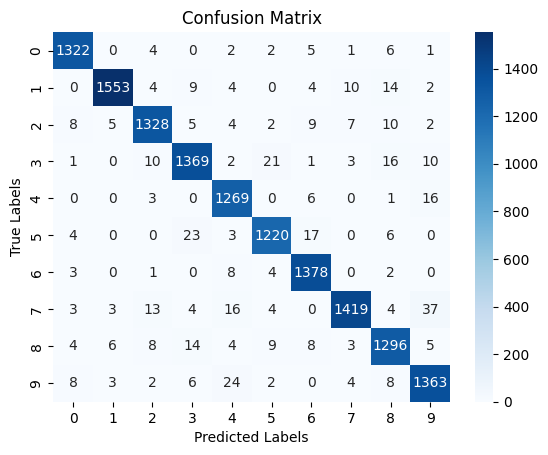

In [23]:
cm_plot(cm_logistic_model_3hlayers)

In [24]:
#### make a flexible function to build model with options of dropout
def deeper_model(dropout=False,dropout_rate=0.3):
  model_layers = [
  tf.keras.Input(shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),]
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),)
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_normal'))

  logistic_model_3hlayers = tf.keras.Sequential(model_layers)
  logistic_model_3hlayers.compile(optimizer='Adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=metrics)
  return logistic_model_3hlayers

threehlayer_model_with_dropout = deeper_model(dropout=True,dropout_rate=0.3)
threehlayer_model_with_dropout.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_3hlayers_dropout = threehlayer_model_with_dropout.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks_model("threehlayer_model_with_dropout"))

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9114 - loss: 0.5185 - val_accuracy: 0.9652 - val_loss: 0.1095
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9506 - loss: 0.1638 - val_accuracy: 0.9786 - val_loss: 0.0629
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9609 - loss: 0.1243 - val_accuracy: 0.9825 - val_loss: 0.0530
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9683 - loss: 0.1011 - val_accuracy: 0.9865 - val_loss: 0.0407
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9724 - loss: 0.0887 - val_accuracy: 0.9906 - val_loss: 0.0337
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9754 - loss: 0.0772 - val_accuracy: 0.9885 - val_loss: 0.0366
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9777 - loss: 0.0722 - val_accuracy: 0.9939 - val_loss: 0.0202
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9793 - loss: 0.06

In [26]:
### evaluate the model
trained_threehlayer_model_with_dropout = tf.keras.models.load_model("threehlayer_model_with_dropout.keras")
trained_threehlayer_model_with_dropout.evaluate(test_data, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9583 - loss: 0.1367


{'accuracy': 0.9575714468955994, 'loss': 0.14221253991127014}

In [27]:
threehlayer_model_with_dropout_prediction_testset, threehlayer_model_with_dropout_label_testset = get_predicted_labels(trained_threehlayer_model_with_dropout, test_data)

cm_threehlayer_model_with_dropout = tf.math.confusion_matrix(threehlayer_model_with_dropout_label_testset, threehlayer_model_with_dropout_prediction_testset)
cm_threehlayer_model_with_dropout

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1318,    1,    2,    0,    2,    1,   11,    2,    4,    2],
       [   0, 1571,    6,    7,    2,    0,    1,    7,    5,    1],
       [   1,    6, 1325,    2,   10,    1,    9,   19,    6,    1],
       [   3,    3,   17, 1329,    2,   37,    3,   18,    6,   15],
       [   1,    0,    4,    0, 1263,    0,    5,    3,    0,   19],
       [   3,    4,    3,   13,    5, 1215,   18,    2,    5,    5],
       [   4,    1,    0,    0,   11,    5, 1375,    0,    0,    0],
       [   5,    9,    9,    0,   12,    1,    0, 1453,    0,   14],
       [   9,   18,   11,   16,    9,   19,   12,    7, 1221,   35],
       [   7,    8,    2,    4,   36,    5,    0,   18,    4, 1336]],
      dtype=int32)>

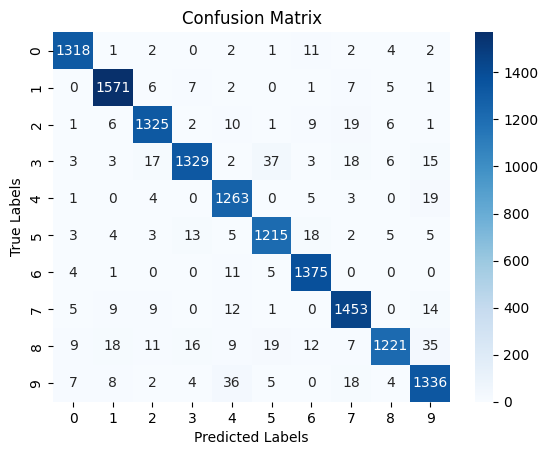

In [28]:
cm_plot(cm_threehlayer_model_with_dropout)

In [29]:
### make model with regularizer l2
#### make a flexible function to build model with options of dropout
def deeper_model(dropout=False,dropout_rate=0.3):
  model_layers = [
  tf.keras.Input(shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.002)),]
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.002)),)
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(0.002)))

  logistic_model_3hlayers = tf.keras.Sequential(model_layers)
  logistic_model_3hlayers.compile(optimizer='Adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=metrics)
  return logistic_model_3hlayers

threehlayer_model_with_dropout_L2 = deeper_model(dropout=True,dropout_rate=0.3)
threehlayer_model_with_dropout_L2.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
## train the mode
history_dropout_L2 = threehlayer_model_with_dropout_L2.fit(train_dataset,
                                                           epochs=50,
                                                           validation_data=val_dataset,
                                                           callbacks=callbacks_model("threehlayer_model_with_dropout_L2"))

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9088 - loss: 1.2560 - val_accuracy: 0.9484 - val_loss: 0.4392
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9301 - loss: 0.5046 - val_accuracy: 0.9621 - val_loss: 0.3832
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9352 - loss: 0.4750 - val_accuracy: 0.9612 - val_loss: 0.3863
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9365 - loss: 0.4699 - val_accuracy: 0.9648 - val_loss: 0.3806
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9380 - loss: 0.4585 - val_accuracy: 0.9587 - val_loss: 0.3895
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9400 - loss: 0.4558 - val_accuracy: 0.9601 - val_loss: 0.3836
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9408 - loss: 0.4515 - val_accuracy: 0.9552 - val_loss: 0.3944
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9387 - loss: 0.45

In [31]:
### evaluate the model
trained_threehlayer_model_with_dropout_L2 = tf.keras.models.load_model("threehlayer_model_with_dropout_L2.keras")
trained_threehlayer_model_with_dropout_L2.evaluate(test_data, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9393 - loss: 0.4692


{'accuracy': 0.9399285912513733, 'loss': 0.4691928029060364}

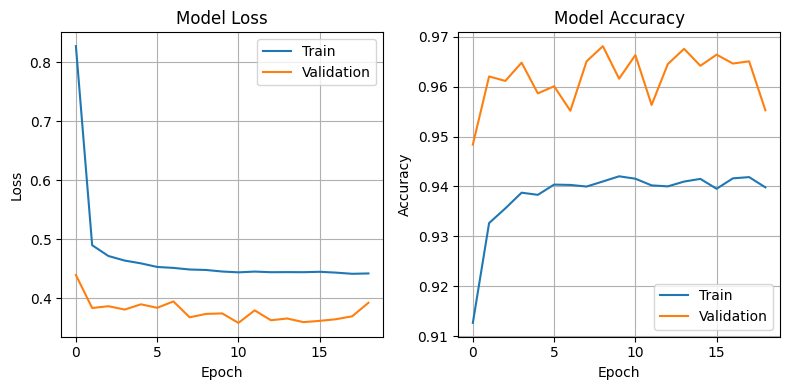

In [32]:
# Assuming history_dropout_L2 is defined and contains training history
plot_training_hist(history_dropout_L2)


In [33]:
## Generate prediction values from the trained model, and extracl
trained_threehlayer_model_with_dropout_L2 = tf.keras.models.load_model("threehlayer_model_with_dropout_L2.keras")
test_results = trained_threehlayer_model_with_dropout_L2.evaluate(test_data, return_dict=True)

threelayerL2_prediction_testset, threelayerL2_label_testset = get_predicted_labels(trained_threehlayer_model_with_dropout_L2, test_data)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9347 - loss: 0.4806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━

In [34]:
len(threelayerL2_prediction_testset) == len(threelayerL2_label_testset)

True

In [35]:
cm_deep_model = tf.math.confusion_matrix(threelayerL2_label_testset, threelayerL2_prediction_testset)
cm_deep_model

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1299,    1,    2,    0,    2,    4,   13,    1,   12,    9],
       [   0, 1567,    4,    8,    1,    3,    1,    2,    8,    6],
       [   2,   10, 1245,   21,   17,    3,   17,   14,   45,    6],
       [   1,    6,    9, 1331,    0,   25,    4,    8,   21,   28],
       [   0,    2,    1,    0, 1207,    0,    8,    0,    1,   76],
       [   4,    3,    1,   31,    7, 1194,   11,    2,   10,   10],
       [   3,    5,    0,    1,   18,   19, 1346,    0,    4,    0],
       [   4,   10,   14,    2,    9,    2,    1, 1350,    2,  109],
       [   1,   11,    2,   25,    6,   15,   11,    4, 1254,   28],
       [   7,    6,    2,    7,   15,    4,    0,    6,    7, 1366]],
      dtype=int32)>

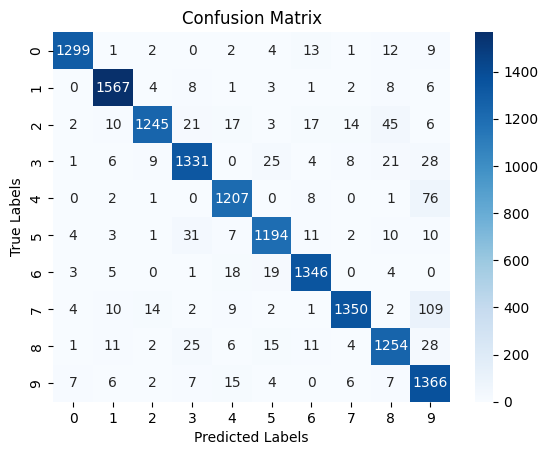

In [36]:
cm_plot(cm_deep_model)

In [37]:
### build a deep learning model using softmax activation function instead of sigmoid, because sigmoid is not good for multilayer deep learning calssification model

def deeper_model(dropout=False,dropout_rate=0.3,output_activation='softmax'):
  model_layers = [
  tf.keras.Input(shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.002)),]
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L2(0.002)),)
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(10, activation=output_activation, kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(0.002)))

  logistic_model_3hlayers = tf.keras.Sequential(model_layers)
  logistic_model_3hlayers.compile(optimizer='Adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=metrics)
  return logistic_model_3hlayers

threeLayers_md_softmax = deeper_model(dropout=True,dropout_rate=0.3)
threeLayers_md_softmax.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
### Train the model
history_softmax = threeLayers_md_softmax.fit(train_dataset,
                                             epochs=50,
                                             validation_data=val_dataset,
                                             callbacks=callbacks_model("threeLayers_md_softmax"))

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8911 - loss: 1.2652 - val_accuracy: 0.9533 - val_loss: 0.4455
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9312 - loss: 0.5027 - val_accuracy: 0.9577 - val_loss: 0.4013
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9328 - loss: 0.4786 - val_accuracy: 0.9646 - val_loss: 0.3727
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9383 - loss: 0.4630 - val_accuracy: 0.9628 - val_loss: 0.3892
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9404 - loss: 0.4590 - val_accuracy: 0.9636 - val_loss: 0.3759
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9373 - loss: 0.4594 - val_accuracy: 0.9655 - val_loss: 0.3734
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9373 - loss: 0.4540 - val_accuracy: 0.9615 - val_loss: 0.3849
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9391 - loss: 0.4554

In [39]:
threeLayers_md_softmax_evaluation = threeLayers_md_softmax.evaluate(test_data, return_dict=True)
threeLayers_md_softmax_evaluation

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.3855


{'accuracy': 0.9580714106559753, 'loss': 0.38444119691848755}

In [40]:
trained_threeLayers_md_softmax = tf.keras.models.load_model("threeLayers_md_softmax.keras")

md_softmax_prediction_testset, md_softmax_label_testset = get_predicted_labels(trained_threeLayers_md_softmax, test_data)

cm_threeLayers_md_softmax = tf.math.confusion_matrix(md_softmax_label_testset, md_softmax_prediction_testset)
cm_threeLayers_md_softmax

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1318,    1,    2,    0,    1,    0,   12,    3,    6,    0],
       [   0, 1567,    7,    6,    1,    1,    2,    7,    8,    1],
       [  14,    9, 1305,    3,    4,    2,   14,   12,   16,    1],
       [   3,    5,   23, 1318,    0,   27,    7,   15,   22,   13],
       [   2,    5,    9,    0, 1193,    0,   29,    7,   14,   36],
       [  14,    6,    2,   18,    6, 1146,   35,    3,   35,    8],
       [   6,    1,    2,    0,    5,    4, 1375,    0,    3,    0],
       [   8,   10,   14,    1,    6,    2,    1, 1451,    3,    7],
       [   8,   12,   13,   18,    4,   11,   20,    6, 1260,    5],
       [  13,   10,    4,    7,   34,    5,    2,   31,   15, 1299]],
      dtype=int32)>

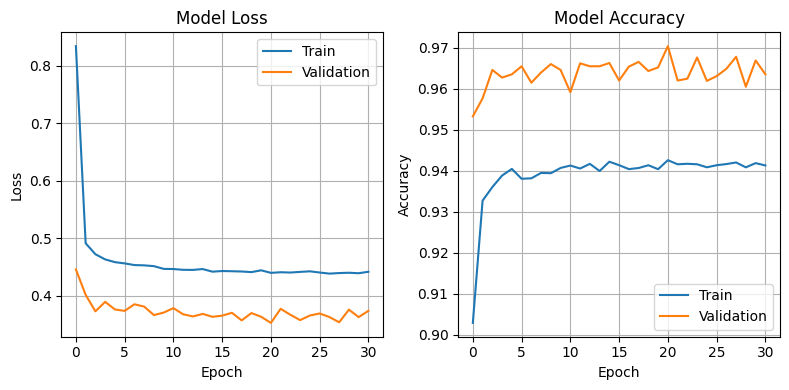

In [41]:
plot_training_hist(history_softmax)

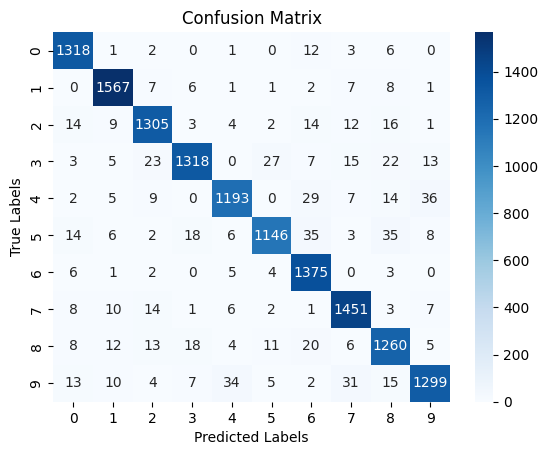

In [42]:
cm_plot(cm_threeLayers_md_softmax)

In [43]:
### build one more deep learning model using softmax activation fucntion without dropout and kernel_regularizer

### build a deep learning model using softmax activation function instead of sigmoid, because sigmoid is not good for multilayer deep learning calssification model

def deeper_model(dropout=False,dropout_rate=0.3,output_activation='softmax'):
  model_layers = [
  tf.keras.Input(shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),]
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),)
  if dropout:
    model_layers.append(tf.keras.layers.Dropout(dropout_rate),)
  model_layers.append(tf.keras.layers.Dense(10, activation=output_activation, kernel_initializer='glorot_normal'))

  logistic_model_3hlayers = tf.keras.Sequential(model_layers)
  logistic_model_3hlayers.compile(optimizer='Adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=metrics)
  return logistic_model_3hlayers

threeLayers_softmax_noL2_noDropout = deeper_model(dropout=False,dropout_rate=0.0)
threeLayers_softmax_noL2_noDropout.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
## train model
softmax_noL2_noDropout = threeLayers_softmax_noL2_noDropout.fit(train_dataset,
                                                                epochs=50,
                                                                validation_data=val_dataset,
                                                                callbacks=callbacks_model("threeLayers_softmax_noL2_noDropout"))
#

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9305 - loss: 0.3691 - val_accuracy: 0.9741 - val_loss: 0.0854
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9711 - loss: 0.0902 - val_accuracy: 0.9831 - val_loss: 0.0569
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9810 - loss: 0.0616 - val_accuracy: 0.9906 - val_loss: 0.0312
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9850 - loss: 0.0446 - val_accuracy: 0.9948 - val_loss: 0.0161
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9888 - loss: 0.0335 - val_accuracy: 0.9937 - val_loss: 0.0188
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.9904 - val_loss: 0.0262
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9920 - loss: 0.0239 - val_accuracy: 0.9946 - val_loss: 0.0156
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9932 - loss: 0.0213

In [45]:
trained_softmax_noL2_noDropout = tf.keras.models.load_model("threeLayers_softmax_noL2_noDropout.keras")
softmax_noL2_noDropout_evaluation = trained_softmax_noL2_noDropout.evaluate(test_data, return_dict=True)

softmax_noL2_noDropout_label_testset, softmax_noL2_noDropout_prediction_testset = get_predicted_labels(trained_softmax_noL2_noDropout, test_data)

cm_softmax_noL2_noDropout = tf.math.confusion_matrix(softmax_noL2_noDropout_label_testset, softmax_noL2_noDropout_prediction_testset)
cm_softmax_noL2_noDropout

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9630 - loss: 0.1251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1322,    0,   11,    0,    2,    4,    8,    1,    5,    5],
       [   1, 1570,    8,    0,    1,    0,    3,    6,    9,    9],
       [   2,    3, 1278,    5,    0,    0,    0,    7,    1,    1],
       [   1,    8,   13, 1356,    1,    5,    0,    9,    8,   17],
       [   3,    2,   13,    2, 1268,    5,   10,    5,    5,   34],
       [   2,    0,    2,   38,    1, 1239,    9,    2,   10,    8],
       [   2,    0,   11,    0,    1,    8, 1361,    0,    4,    0],
       [   3,    3,   15,    8,    2,    0,    0, 1467,    4,   33],
       [   6,   14,   28,   22,    5,   12,    5,    4, 1310,   27],
       [   1,    0,    1,    2,   14,    0,    0,    2,    1, 1286]],
      dtype=int32)>

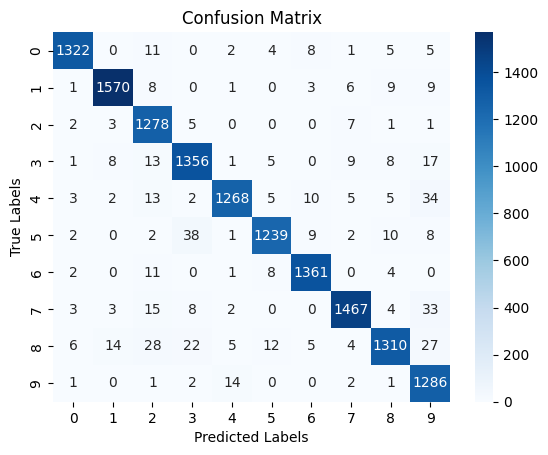

In [46]:
cm_plot(cm_softmax_noL2_noDropout)

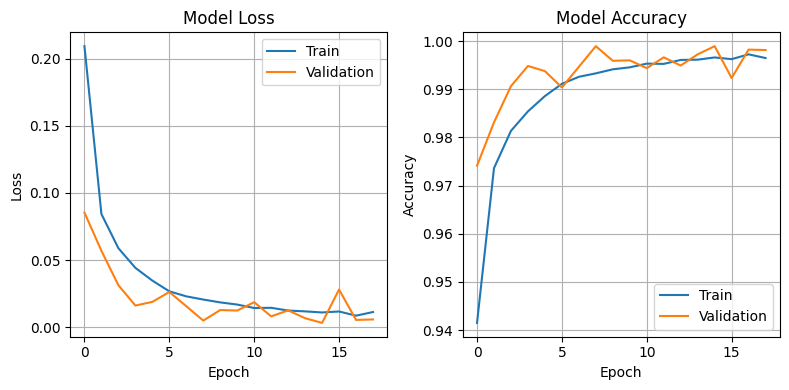

In [47]:
plot_training_hist(softmax_noL2_noDropout)